In [84]:
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import numpy as np
from sklearn.metrics import accuracy_score

### Pretprocesiranje podataka

In [85]:
df = pd.read_pickle('dataset.pkl')
df.head()

,Age(years),Height(cm),Parity,ANC,Iwt(kg),FWt(kg),IBP_sys,IBP_dias,FBP_sys,FBP_dias,IHb(gm%),FHb(gm%),Sex,BWt(kg),LNH
0,0.319149,0.735135,0.166667,1.000000,0.085106,0.170213,0.595506,0.633333,0.785714,0.389610,0.645161,1.000000,0,0.594595,2
1,0.361702,0.837838,0.166667,0.666667,0.808511,0.787234,0.483146,0.500000,0.714286,0.415584,0.709677,0.811966,1,0.648649,2
2,0.340426,0.783784,0.166667,0.666667,0.404255,0.446809,0.455056,0.200000,0.714286,0.389610,0.806452,0.863248,1,0.513514,1
3,0.234043,0.778378,0.166667,0.333333,0.404255,0.340426,0.449438,0.200000,0.642857,0.259740,0.645161,0.777778,0,0.567568,2
4,0.276596,0.756757,0.166667,1.000000,0.234043,0.297872,0.505618,0.333333,0.714286,0.389610,0.483871,0.743590,0,0.486486,1


In [86]:
df['LNH'].unique()

array([2, 1])

S obzirom na to da se značajka _LNH_ sastoji od samo 2 vrijednosti, napravit ćemo one-hot encoding, da kasnije bude lakše trenirati modele. U slučaju kad _LNH = 1_, odnosno kad je njena vrijednost _low-weight_, ostavit ćemo vrijednost 1. U slučaju kad _LNH = 2_, ondosno kad je njena vrijednost _normal-weight_, promijenit ćemo vrijednost značajke u 0.

Također, s obzirom na to da se ciljna značajka _LNH_ računa prema vrijednostima značajke _BWt(kg)_, ta značajka postaje redudantna. Stoga ćemo ju ukloniti iz skupa podataka.

In [87]:
df.loc[df['LNH'] == 2, 'LNH'] = 0
df = df.drop(columns=['BWt(kg)'])
df.head()

,Age(years),Height(cm),Parity,ANC,Iwt(kg),FWt(kg),IBP_sys,IBP_dias,FBP_sys,FBP_dias,IHb(gm%),FHb(gm%),Sex,LNH
0,0.319149,0.735135,0.166667,1.000000,0.085106,0.170213,0.595506,0.633333,0.785714,0.389610,0.645161,1.000000,0,0
1,0.361702,0.837838,0.166667,0.666667,0.808511,0.787234,0.483146,0.500000,0.714286,0.415584,0.709677,0.811966,1,0
2,0.340426,0.783784,0.166667,0.666667,0.404255,0.446809,0.455056,0.200000,0.714286,0.389610,0.806452,0.863248,1,1
3,0.234043,0.778378,0.166667,0.333333,0.404255,0.340426,0.449438,0.200000,0.642857,0.259740,0.645161,0.777778,0,0
4,0.276596,0.756757,0.166667,1.000000,0.234043,0.297872,0.505618,0.333333,0.714286,0.389610,0.483871,0.743590,0,1


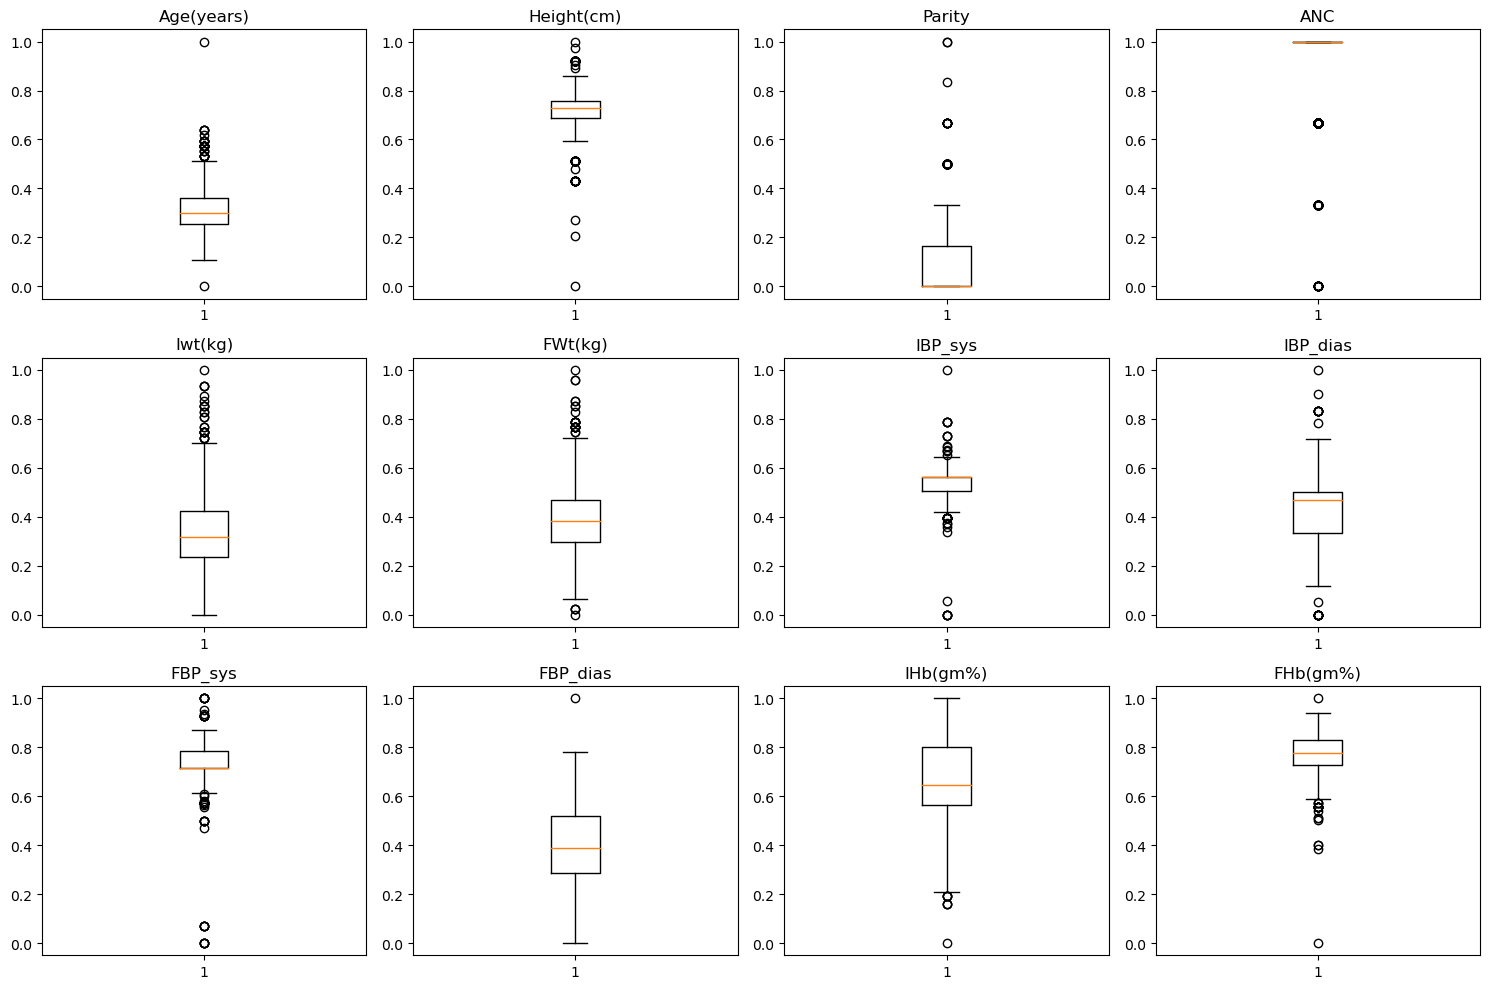

In [88]:
fig, ax = plt.subplots(3, 4, figsize=(15, 10))

ax[0,0].boxplot(df['Age(years)'])
ax[0,0].set_title('Age(years)')
ax[0,1].boxplot(df['Height(cm)'])
ax[0,1].set_title('Height(cm)')
ax[0,2].boxplot(df['Parity'])
ax[0,2].set_title('Parity')
ax[0,3].boxplot(df['ANC'])
ax[0,3].set_title('ANC')
ax[1,0].boxplot(df['Iwt(kg)'])
ax[1,0].set_title('Iwt(kg)')
ax[1,1].boxplot(df['FWt(kg)'])
ax[1,1].set_title('FWt(kg)')
ax[1,2].boxplot(df['IBP_sys'])
ax[1,2].set_title('IBP_sys')
ax[1,3].boxplot(df['IBP_dias'])
ax[1,3].set_title('IBP_dias')
ax[2,0].boxplot(df['FBP_sys'])
ax[2,0].set_title('FBP_sys')
ax[2,1].boxplot(df['FBP_dias'])
ax[2,1].set_title('FBP_dias')
ax[2,2].boxplot(df['IHb(gm%)'])
ax[2,2].set_title('IHb(gm%)')
ax[2,3].boxplot(df['FHb(gm%)'])
ax[2,3].set_title('FHb(gm%)')


fig.tight_layout()
plt.show()

In [89]:
# https://www.geeksforgeeks.org/detect-and-remove-the-outliers-using-python/

print('Broj zapisa prije izbacivanja outliera:', len(df))
df_copy = df.copy()

for col in df_copy.loc[:, ~df_copy.columns.isin(['LNH', 'Sex', 'Parity', 'ANC'])].columns:
    z = np.abs(stats.zscore(df_copy[col]))
    outlier_indices = np.where(z > 3.0)[0]
    df_copy = df_copy.drop(df_copy.index[outlier_indices])

print('Broj zapisa nakon izbacivanja outliera:', len(df_copy))
df = df_copy.copy()

Broj zapisa prije izbacivanja outliera: 1038
Broj zapisa nakon izbacivanja outliera: 941


### Podjela na set za treniranje i set za testiranje (70/30)

In [105]:
from sklearn.model_selection import train_test_split

X = df.drop('LNH', axis=1)
y = df['LNH']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

len(X_train), len(X_test)

(658, 283)

### Gaussian Naive Bayes

In [106]:
from sklearn.naive_bayes import GaussianNB

## Fitting

gnb = GaussianNB()
gnb.fit(X_train, y_train)

GaussianNB()

In [108]:
## Predictions

y_pred_train = gnb.predict(X_train)
acc_train = accuracy_score(y_train, y_pred_train)
print(f'Train acc = {acc_train:.3f}')
y_pred = gnb.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f'Test acc = {acc:.3f}')

Train acc = 0.822
Test acc = 0.848


### Random forest

In [109]:
from sklearn.ensemble import RandomForestClassifier

## Fitting

clf = RandomForestClassifier()
clf.fit(X_train, y_train)

RandomForestClassifier()

In [110]:
y_pred_train = clf.predict(X_train)
acc_train = accuracy_score(y_train, y_pred_train)
print(f'Train acc = {acc_train:.3f}')
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f'Test acc = {acc:.3f}')

Train acc = 1.000
Test acc = 0.894


### Logistic regression

In [111]:
from sklearn.linear_model import LogisticRegression

reg = LogisticRegression()
reg.fit(X_train, y_train)

LogisticRegression()

In [112]:
y_pred_train = reg.predict(X_train)
acc_train = accuracy_score(y_train, y_pred_train)
print(f'Train acc = {acc_train:.3f}')
y_pred = reg.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f'Test acc = {acc:.3f}')

Train acc = 0.848
Test acc = 0.894


### SVM

In [113]:
from sklearn.svm import SVC

svm = SVC(kernel='rbf')
svm.fit(X_train, y_train)

SVC()

In [114]:
y_pred_train = svm.predict(X_train)
acc_train = accuracy_score(y_train, y_pred_train)
print(f'Train acc = {acc_train:.3f}')
y_pred = svm.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f'Test acc = {acc:.3f}')

Train acc = 0.848
Test acc = 0.894
